<a href="https://colab.research.google.com/github/Pluviophile-1/-/blob/main/%E4%BD%9C%E4%B8%9A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание 1

In [ ]:
!pip install -U -q google-colab google-auth
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.7 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Импортирование необходимых библиотек

In [ ]:
from PIL import Image
from glob import glob
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
from tensorflow import summary as tfsummary
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext tensorboard

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Чтение тренировочной и тестовой выборки

Инструкция для скачивания и загрузки фотографий в Сolab находится в github




In [ ]:
heigth_width = 32

CLASSES = ['giant_panda', 'snow_leopard', 'cat'] # Здесь требуется указать ваши классы

images = []
images_t = []
classes = []
classes_t = []

for CLASS in range(0, len(CLASSES)):
  path_class_1 = "/content/drive/MyDrive/%s/*.*"%CLASSES[CLASS]
  i=0
  for photo in glob(path_class_1):
      i+=1
      img = Image.open(photo).convert('RGB')
      img = img.resize((heigth_width, heigth_width), Image.Resampling.LANCZOS)
      if i > int(len(os.listdir("/content/drive/MyDrive/%s/"%CLASSES[CLASS]))*0.8):
          images_t.append(np.asarray(img))
          classes_t.append(np.asarray(CLASS))
      else:
          images.append(np.asarray(img))
          classes.append(np.asarray(CLASS))


train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)

###Приведение фотографий к требуемому размеру

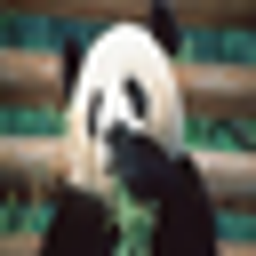

In [ ]:
Image.fromarray(train_X[50]).resize((256,256))

262 68


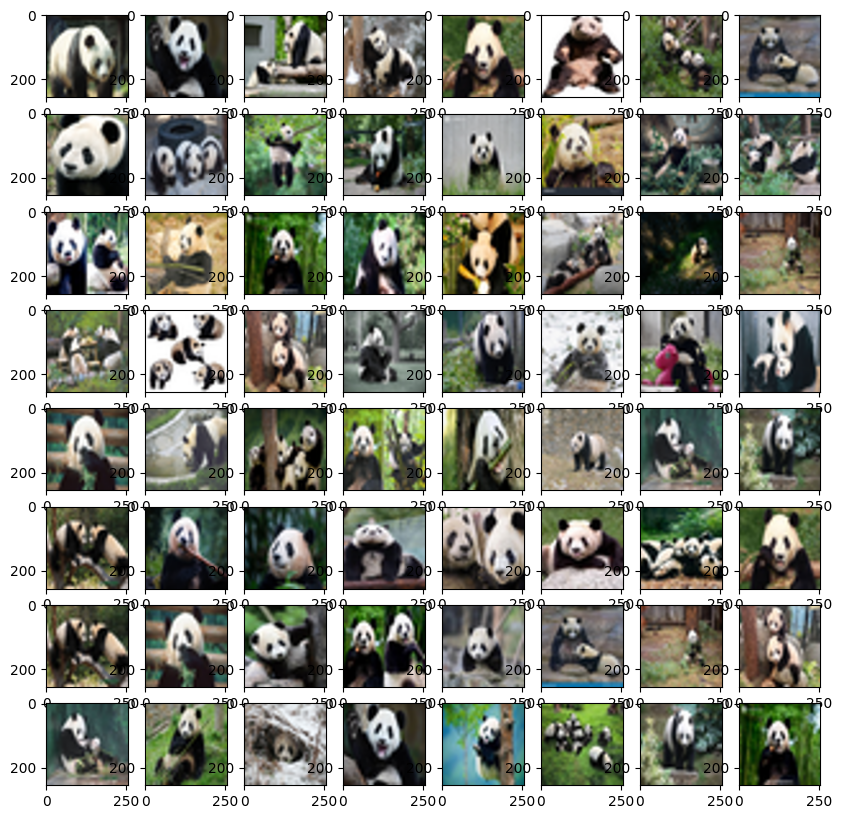

In [ ]:
print(len(train_X), len(test_X))

fig = plt.figure(figsize=(10, 10))
columns = 8
rows = 8

for i in range(1, columns*rows +1):
    # Без аугментации
    img = Image.fromarray(train_X[i]).resize((256,256)) # без аугментации
    # С аугментацией
    # img = Image.fromarray((transform(torch.Tensor(train_X[i]).permute(2, 0, 1)/255.).\
    #             permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
    #             resize((256, 256))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

# Аугментация данных

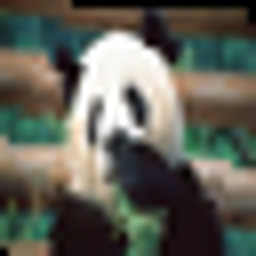

In [ ]:
class CifarDataset(Dataset):
     def __init__(self, X, y, transform=None, p=0.0):
         assert X.size(0) == y.size(0)
         super(Dataset, self).__init__()
         self.X = X
         self.y = y
         self.transform = transform
         self.prob = p

     def __len__(self):
         return self.y.size(0)

     def __getitem__(self, index):
        x = self.X[index]
        if self.transform and np.random.random()<self.prob:
            x = self.transform(x.permute(2, 0, 1)/255.).permute(1, 2, 0)*255.
        y = self.y[index]
        return x, y

transform = T.Compose([
     T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05, hue=0.0),
     T.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.95, 1.05),
                    shear=5),
])
#transform = T.AutoAugment(T.AutoAugmentPolicy.CIFAR10)

Image.fromarray((transform(torch.Tensor(train_X[50]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

##Создание Pytorch DataLoader'a

In [ ]:
batch_size = 64
dataloader = {}
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = CifarDataset(tensor_x, tensor_y,
                           transform if part=='train' else None,
                           p=0.5) # создание объекта датасета
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7ca954187e10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7ca95431ec50>}

##Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [ ]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm

class GlobalMaxPool2d(nn.Module):
    def __init__(self):
        super(GlobalMaxPool2d, self).__init__()

    def forward(self, input):
        out = F.adaptive_max_pool2d(input, output_size=1)
        return out.flatten(start_dim=1)

class Cifar100_MLP(nn.Module):
    def __init__(self, hidden_size=32, classes=100):
        super(Cifar100_MLP, self).__init__()
        # https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
        self.seq = nn.Sequential(
            Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),
            # первый способ уменьшения размерности картинки - через stride
            nn.Conv2d(3, HIDDEN_SIZE, 3, stride=4),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            # второй способ уменьшения размерности картинки - через слой пуллинг
            nn.Conv2d(HIDDEN_SIZE, HIDDEN_SIZE*2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(4),#nn.MaxPool2d(4),
            nn.Dropout2d(p=0.3),
            nn.Flatten(),
            nn.Linear(HIDDEN_SIZE*8, classes),
        )

    def forward(self, input):
        return self.seq(input)

model = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       #"cifar100_mobilenetv2_x0_5",
                       'cifar100_resnet20',
                       pretrained=True)
model.to(device)
new_model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model
).to(device)
print(new_model(torch.rand(1, 32, 32, 3).to(device)))
summary(new_model, input_size=(32, 32, 3))
new_model

tensor([[-1.6178e+00, -9.7331e-02,  5.4830e-01,  6.7673e-01,  6.1605e-01,
         -7.0986e-01, -7.8597e-01,  6.5680e-01, -2.4338e-01,  3.5489e-01,
          1.0876e+00,  1.1172e+00, -2.2101e-01, -4.3734e-01,  4.6210e-01,
          3.7251e-01,  4.5737e-01, -5.0102e-01,  8.3368e-01,  6.8644e-01,
         -1.0076e+00, -9.8852e-01,  2.9124e-01, -6.0158e-01, -9.5740e-01,
          1.1037e+00, -8.5950e-02, -8.6597e-01, -5.4198e-01,  1.2072e+00,
         -1.0033e+00,  3.8716e-02,  1.4037e+00,  5.7266e-01, -4.2644e-05,
          5.4265e-01, -2.6653e-01,  2.3418e-01,  2.6938e-01, -1.0017e+00,
          1.4483e+00, -2.1894e-02,  5.3359e-01, -1.1605e+00,  1.3220e+00,
          8.5717e-01,  1.3594e+00, -1.3514e+00, -4.4223e-01, -9.4141e-01,
          1.2931e+00,  8.3557e-01, -1.9206e+00, -2.0975e+00, -7.3683e-01,
          5.5585e-01, -3.4164e-01,  7.6003e-01, -2.0605e+00,  5.4200e-02,
         -1.5183e+00, -9.5244e-01, -1.8494e-01,  5.4808e-01,  8.1892e-01,
          1.0598e+00,  8.2513e-01,  1.

Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Sequential(
  (0): Normalize()
  (1): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): 

In [ ]:
summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 512, 512]             432
       BatchNorm2d-2         [-1, 16, 512, 512]              32
              ReLU-3         [-1, 16, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           2,304
       BatchNorm2d-5         [-1, 16, 512, 512]              32
              ReLU-6         [-1, 16, 512, 512]               0
            Conv2d-7         [-1, 16, 512, 512]           2,304
       BatchNorm2d-8         [-1, 16, 512, 512]              32
              ReLU-9         [-1, 16, 512, 512]               0
       BasicBlock-10         [-1, 16, 512, 512]               0
           Conv2d-11         [-1, 16, 512, 512]           2,304
      BatchNorm2d-12         [-1, 16, 512, 512]              32
             ReLU-13         [-1, 16, 512, 512]               0
           Conv2d-14         [-1, 16, 5

In [ ]:
#!git clone https://github.com/Fangyh09/pytorch-receptive-field.git
def compute_RF_numerical(net,img_np):
    '''
    @param net: Pytorch network
    @param img_np: numpy array to use as input to the networks, it must be full of ones and with the correct
    shape.
    '''
    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.fill_(1)
            m.bias.data.fill_(0)
    #net.apply(weights_init)
    img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)
    out_cnn=net(img_.to(device))
    out_shape=out_cnn.size()
    ndims=len(out_cnn.size())
    grad=torch.zeros(out_cnn.size())
    l_tmp=[]
    for i in range(ndims):
        if i==0 or i ==1:#batch or channel
            l_tmp.append(0)
        else:
            l_tmp.append(out_shape[i]/2)

    grad[tuple(l_tmp)]=1
    out_cnn.backward(gradient=grad.to(device))
    grad_np=img_.grad[0,0].data.detach().cpu().numpy()
    idx_nonzeros=np.where(grad_np!=0)
    RF=[np.max(idx)-np.min(idx)+1 for idx in idx_nonzeros]

    return RF

compute_RF_numerical(model, np.zeros((1, 3, 1024, 1024)))

<ipython-input-54-0d0f494b73ca>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_ = torch.tensor(torch.from_numpy(img_np).float(),requires_grad=True)


[np.int64(1024), np.int64(1024)]

In [ ]:
## mobilenetv2
#in_features = new_model[1].classifier[1].in_features
#new_model[1].classifier[1] = nn.Linear(in_features=in_features,
#                                       out_features=len(CLASSES),
#                                       bias=True)
## resnet20
in_features = new_model[1].fc.in_features
new_model[1].fc = nn.Linear(in_features=in_features,
                            out_features=len(CLASSES),
                            bias=True)

new_model.to(device)
summary(new_model, input_size=(32, 32, 3))
print(new_model(torch.rand(1, 32, 32, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

# Заморозка весов

In [ ]:
print("Обучаемые параметры:")
keep_last = 60
total = len([*new_model.named_parameters()])
params_to_update = []
for i, (name, param) in enumerate(new_model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False
    else:
        params_to_update.append(param)
        param.requires_grad = True
        print("\t",name)
summary(new_model, input_size=(32, 32, 3))

Обучаемые параметры:
	 1.layer1.0.bn1.bias
	 1.layer1.0.conv2.weight
	 1.layer1.0.bn2.weight
	 1.layer1.0.bn2.bias
	 1.layer1.1.conv1.weight
	 1.layer1.1.bn1.weight
	 1.layer1.1.bn1.bias
	 1.layer1.1.conv2.weight
	 1.layer1.1.bn2.weight
	 1.layer1.1.bn2.bias
	 1.layer1.2.conv1.weight
	 1.layer1.2.bn1.weight
	 1.layer1.2.bn1.bias
	 1.layer1.2.conv2.weight
	 1.layer1.2.bn2.weight
	 1.layer1.2.bn2.bias
	 1.layer2.0.conv1.weight
	 1.layer2.0.bn1.weight
	 1.layer2.0.bn1.bias
	 1.layer2.0.conv2.weight
	 1.layer2.0.bn2.weight
	 1.layer2.0.bn2.bias
	 1.layer2.0.downsample.0.weight
	 1.layer2.0.downsample.1.weight
	 1.layer2.0.downsample.1.bias
	 1.layer2.1.conv1.weight
	 1.layer2.1.bn1.weight
	 1.layer2.1.bn1.bias
	 1.layer2.1.conv2.weight
	 1.layer2.1.bn2.weight
	 1.layer2.1.bn2.bias
	 1.layer2.2.conv1.weight
	 1.layer2.2.bn1.weight
	 1.layer2.2.bn1.bias
	 1.layer2.2.conv2.weight
	 1.layer2.2.bn2.weight
	 1.layer2.2.bn2.bias
	 1.layer3.0.conv1.weight
	 1.layer3.0.bn1.weight
	 1.layer3.0.bn1.b

# Fine tunning

In [ ]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
optimizer = optim.SGD(params_to_update, lr=3e-3, momentum=0.9,
                      weight_decay=5e-4)
# добавляем постепенное уменьшение шага обучения каждые 20 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

##Обучение модели по эпохам

Эпоха: 60
Лучшая доля правильных ответов: 96.875
Текущая доля правильных ответов: 83.59375


  0%|          | 0/300 [00:00<?, ?it/s]

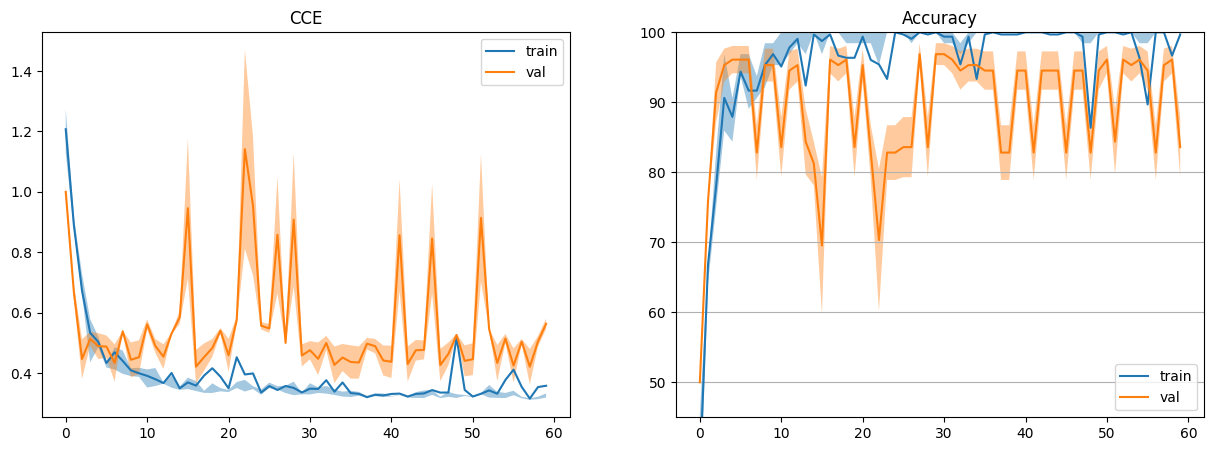

Обучение закончено за 112.97114181518555 секунд


In [ ]:
EPOCHS = 60
REDRAW_EVERY = 10
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
checkpoint_path = 'cifar_cnn_fine.pth'
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    new_model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    new_model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        torch.save(new_model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшая доля правильных ответов: %s\n'
          'Текущая доля правильных ответов: %s' % (epoch+1, best_acc, acc))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
new_model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

##Проверка качества модели по классам на обучающей и тестовой выборках

In [ ]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

 giant_panda     1.0000    1.0000    1.0000        85
snow_leopard     1.0000    1.0000    1.0000        81
         cat     1.0000    1.0000    1.0000        96

    accuracy                         1.0000       262
   macro avg     1.0000    1.0000    1.0000       262
weighted avg     1.0000    1.0000    1.0000       262

--------------------------------------------------
test
              precision    recall  f1-score   support

 giant_panda     1.0000    0.8636    0.9268        22
snow_leopard     0.9091    0.9524    0.9302        21
         cat     0.9259    1.0000    0.9615        25

    accuracy                         0.9412        68
   macro avg     0.9450    0.9387    0.9395        68
weighted avg     0.9447    0.9412    0.9406        68

--------------------------------------------------


##Сохранение модели в ONNX

In [ ]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_cnn_fine.pth'
torch.save(new_model.state_dict(), PATH)

# ВТОРОЙ СПОСОБ: сохранение всей архитектуры
PATH2 = 'cifar_cnn_fine.pt'
torch.save(new_model, PATH2)
# загрузка
new_model_2 = torch.load(PATH2, weights_only=False)
new_model_2.eval()

Sequential(
  (0): Normalize()
  (1): CifarResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): 

In [ ]:
class GlobalAvgPooling2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPooling2d, self).__init__()

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (1, 1))
        return torch.flatten(x, 1)

class MyModel(nn.Module):

    def __init__(self, model):
        super(MyModel, self).__init__()

        # Here you get the bottleneck/feature extractor
        self.normalization = model[0]
        self.resnet_feature_extractor = \
                nn.Sequential(*list(model[1].children())[:-1])

        # Now you can include your classifiers
        self.classifier = list(model[1].children())[-1]

    # Set your own forward pass
    def forward(self, x, extra_info=None):
        x = self.normalization(x)
        x = self.resnet_feature_extractor(x)
        x = self.classifier(x)
        return x

new_model = torch.load(PATH2, weights_only=False)
new_model[1].avgpool = GlobalAvgPooling2d()
new_model.to(device)
model = MyModel(new_model).to(device)

summary(model, input_size=(32, 32, 3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 32, 32]               0
            Conv2d-2           [-1, 16, 32, 32]             432
       BatchNorm2d-3           [-1, 16, 32, 32]              32
              ReLU-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
              ReLU-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
             ReLU-10           [-1, 16, 32, 32]               0
       BasicBlock-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 53.3 MB/s eta 0:00:00


In [ ]:
# входной тензор для модели
x = torch.randn(1, 32, 32, 3, requires_grad=True).to(device)
torch_out = model(x)

# экспорт модели
torch.onnx.export(model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_CNN_RESNET20.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})